In [1]:
DATE = "2022-02-20"
TASK = "sample-core-genome"
DIR = mkpath("$(homedir())/workspace/$(DATE)-$(TASK)")
cd(DIR)

In [28]:
pkgs = [
    "Graphs",
    "MetaGraphs",
    "FileIO",
    "JLD2",
    "DataStructures",
    "BioSequences",
    "Random",
    "FASTX",
    # "Revise",
    "StatsBase",
    "Statistics",
    "Clustering",
    "StatsPlots",
    "Primes"
]

import Pkg
# Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $(pkg)"))
end

import Mycelia

In [5]:
function update_remaining_targets(current_walk::AbstractVector{T}, remaining_targets::AbstractSet{T}) where T <: BioSequences.AbstractMer
    # assess whether targets have been hit in the canonical space
    remaining_targets = setdiff(BioSequences.canonical.(remaining_targets), BioSequences.canonical.(current_walk))
    # blow back out into forward and reverse_complement space
    remaining_targets = Set{T}(vcat(remaining_targets, BioSequences.reverse_complement.(remaining_targets)))
    return remaining_targets
end

update_remaining_targets (generic function with 1 method)

In [6]:
function observe(records::AbstractVector{R};
                weights=ones(length(records)),
                N = length(records),
                outfile = "",
                error_rate = 0.0) where {R <: Union{FASTX.FASTA.Record, FASTX.FASTQ.Record}}
    if isempty(outfile)
        error("no file name supplied")
    end
    io = open(outfile, "w")
    fastx_io = FASTX.FASTA.Writer(io)
    for i in 1:N
        record = StatsBase.sample(records, StatsBase.weights(weights))
        new_seq = Mycelia.observe(FASTX.sequence(record), error_rate=error_rate)
        new_seq_id = Random.randstring(Int(ceil(log(length(new_seq) + 1))))
        new_seq_description = FASTX.identifier(record)
        observed_record = FASTX.FASTA.Record(new_seq_id, new_seq_description, new_seq)
        write(fastx_io, observed_record)
    end
    close(fastx_io)
    close(io)
    return outfile
end

observe (generic function with 1 method)

In [7]:
function assess_downstream_weight(graph, kmer)
    # here we look to see if walking forward or backward from the initial node gets us to heavier weight options
    score = 0
    for neighbor in BioSequences.neighbors(kmer)
        try
            score += MetaGraphs.get_prop(graph, graph[BioSequences.canonical(neighbor), :kmer], :count)
        catch
            continue
        end
    end
    return score
end

assess_downstream_weight (generic function with 1 method)

In [8]:
# vertices should either be entire graph (by default) or a connected component
# if people want to work on just the connected component, let them induce a subgraph
function find_graph_core(graph; seed=rand(Int))
    
    Random.seed!(seed)
    
    T = typeof(MetaGraphs.get_prop(graph, 1, :kmer))
    
    targets = [MetaGraphs.get_prop(graph, v, :kmer) for v in Graphs.vertices(graph)]
    
    starting_kmer = first(targets)
    max_degree = 0
    for node in targets
        node_degree = Graphs.degree(graph, graph[node, :kmer])
        if node_degree > max_degree
            max_degree = node_degree
            starting_kmer = node
        end
    end
        
    current_walk = [starting_kmer]
    prior_walk_length = length(current_walk)
    remaining_targets = update_remaining_targets(current_walk, targets)
    done = isempty(remaining_targets)
    
    while !done
        # here we look to see if walking forward or backward from the current ends gets us to heavier weight options
        # we want to prioritize walks toward higher coverage nodes
        forward_score = assess_downstream_weight(graph, last(current_walk))
        reverse_score = assess_downstream_weight(graph, BioSequences.reverse_complement(first(current_walk)))
        if reverse_score > forward_score
            current_walk = reverse(BioSequences.reverse_complement.(current_walk))
        end
        
        forward_source = last(current_walk)
        forward_walk, forward_distance = Mycelia.dijkstra(graph, forward_source, remaining_targets, search_strategy=:DFS)
        current_walk = vcat(current_walk, forward_walk[2:end])
        remaining_targets = update_remaining_targets(current_walk, remaining_targets)
        if isempty(remaining_targets)
            done = true
        else
            reverse_source = BioSequences.reverse_complement(first(current_walk))
            reverse_walk, reverse_distance = Mycelia.dijkstra(graph, reverse_source, remaining_targets, search_strategy=:DFS)
            current_walk = vcat(reverse(BioSequences.reverse_complement.(reverse_walk))[1:end-1], current_walk)
            remaining_targets = update_remaining_targets(current_walk, remaining_targets)
            current_walk
        end
        failed_this_expansion = length(current_walk) == prior_walk_length
        prior_walk_length = length(current_walk)
        if isempty(remaining_targets)
            done = true
        elseif failed_this_expansion
            done = true
        end
    end
    return current_walk
end

find_graph_core (generic function with 1 method)

In [20]:
function apply_kmedoids_treshold(graph)
    kmer_counts = [MetaGraphs.get_prop(graph, v, :count) for v in Graphs.vertices(graph)]

    kmer_counts_histogram = sort(collect(StatsBase.countmap(values(kmer_counts))), by=x->x[1])

    scale = 250
    p = Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), size=(2scale,scale), log_scale=log2, title="kmer frequencies")
    display(p)

    p = StatsPlots.scatter(log2.(first.(kmer_counts_histogram)))
    display(p)

    kmer_depth_of_coverage_bins = log2.(first.(kmer_counts_histogram))

    distance_matrix = zeros((length(kmer_depth_of_coverage_bins), length(kmer_depth_of_coverage_bins)))
    for (row, depth_of_coverage_bin_1) in enumerate(kmer_depth_of_coverage_bins)
        for (col, depth_of_coverage_bin_2) in enumerate(kmer_depth_of_coverage_bins)
            distance = abs(depth_of_coverage_bin_1 - depth_of_coverage_bin_2)
            distance_matrix[row, col] = distance
        end
    end
    distance_matrix

    # max out k at the same max k we use for DNAMers
    max_k = min(length(kmer_depth_of_coverage_bins), 63)
    ks = Primes.primes(2, max_k)
    ys = map(k ->
                Statistics.mean(Statistics.mean(Clustering.silhouettes(Clustering.kmedoids(distance_matrix, k), distance_matrix)) for i in 1:100),
                ks)

    p = StatsPlots.plot(ks, ys, label="silhouette score", ylabel = "silhouette score", xlabel = "number of clusters")
    display(p)

    ymax, ymax_index = findmax(ys)
    optimal_k = ks[ymax_index]
    clusterings = [Clustering.kmedoids(distance_matrix, optimal_k) for i in 1:10]
    max_value, max_value_index = findmax(clustering -> Statistics.mean(Clustering.silhouettes(clustering, distance_matrix)), clusterings)
    optimal_clustering = clusterings[max_value_index]
    # optimal_clustering.assignments
    min_medoid_value, min_medoid_index = findmin(optimal_clustering.medoids)
    indices_to_include = map(assignment -> assignment .!= min_medoid_index, optimal_clustering.assignments)
    # kmer_depth_of_coverage_bins
    threshold = Int(ceil(2^maximum(kmer_depth_of_coverage_bins[.!indices_to_include]))) + 1

    scale = 250
    p = Mycelia.plot_kmer_frequency_spectra(values(kmer_counts), log_scale = log2, size=(2scale,scale), title="kmer frequencies")
    StatsPlots.vline!(p, log2.([threshold]))
    display(p)

    # find all vertices with count > threshold
    vertices_to_keep = [v for v in Graphs.vertices(graph) if (MetaGraphs.get_prop(graph, v, :count) > threshold)]
    # induce subgraph
    induced_subgraph, vertex_map = Graphs.induced_subgraph(graph, vertices_to_keep)

    # set kmer as indexing prop
    MetaGraphs.set_indexing_prop!(induced_subgraph, :kmer)
    return induced_subgraph
end

In [10]:
# Create a reference sequence
L = 100
seed = 0
# seed = 1
# seed = 2
# seed = 3
# seed = 4
# seed = 5
# seed = 6
# seed = 7
# seed = 8
# seed = 9
record = Mycelia.random_fasta_record(seed=seed, L=L)

FASTX.FASTA.Record:
   identifier: Cz2Gr
  description: <missing>
     sequence: TAAGCTATTGCGCTTGGCAATTAAGCACAACCTTCGACC…

In [11]:
error_rate = 0.1

0.1

In [12]:
observations_file = "$(DIR)/N-$L.observations.fasta"
observe([record], N=L, outfile=observations_file, error_rate=error_rate)

"/home/jupyter-cjprybol/workspace/2022-02-20-sample-core-genome/N-100.observations.fasta"

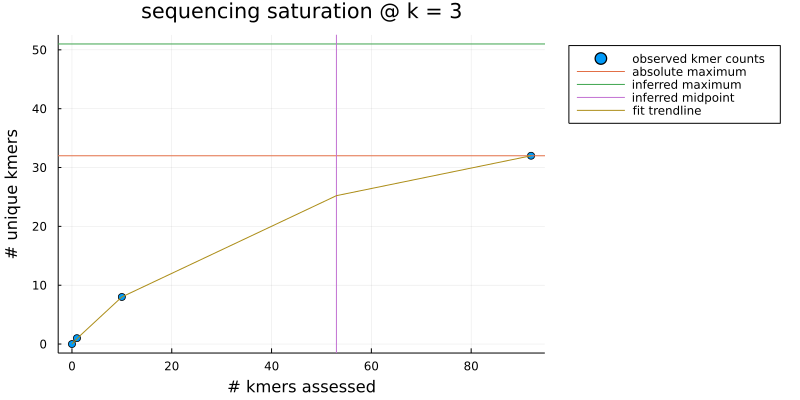

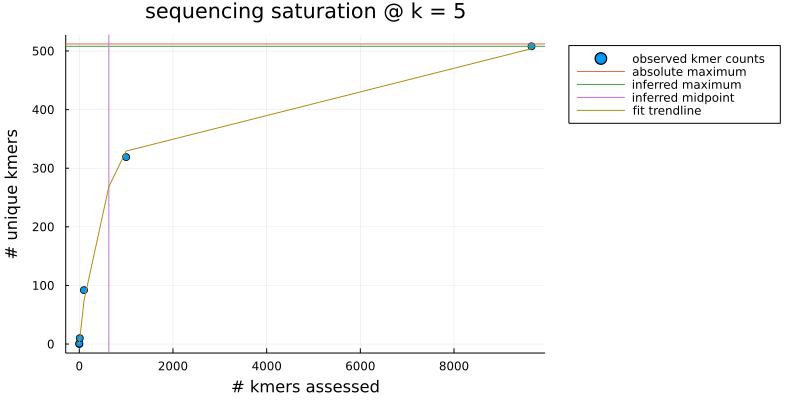

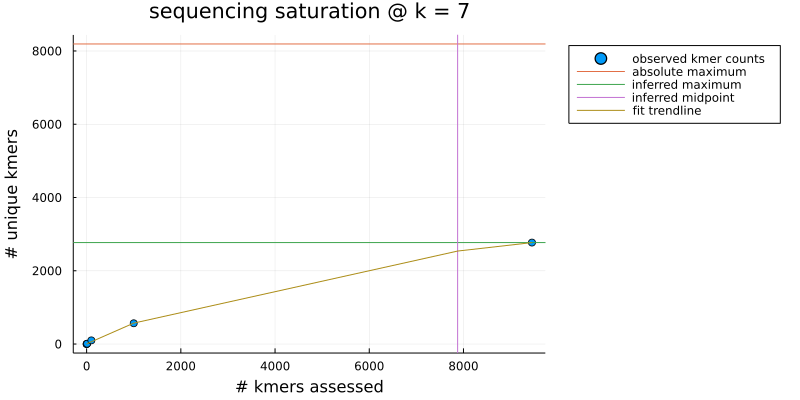

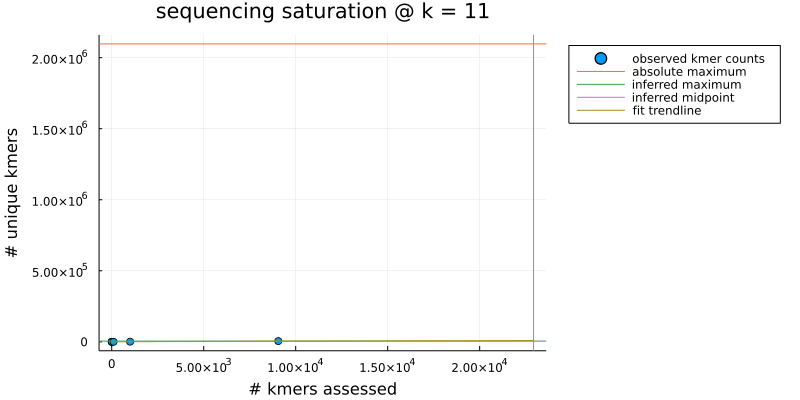

(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 92], [0, 1, 8, 32], false)
  5.174168 seconds (9.02 M allocations: 465.509 MiB, 4.23% gc time, 99.97% compilation time)
(k, predicted_saturation) = (3, 1.59375)
(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 100, 1000, 9654], [0, 1, 10, 92, 319, 508], true)
  0.000097 seconds (245 allocations: 23.047 KiB)
(k, predicted_saturation) = (5, 0.9921875)
(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 100, 1000, 9454], [0, 1, 10, 100, 567, 2770], true)
  0.000081 seconds (245 allocations: 23.047 KiB)
(k, predicted_saturation) = (7, 0.338134765625)
(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 100, 1000, 9054], [0, 1, 10, 100, 735, 4998], true)
  0.000079 seconds (254 allocations: 23.750 KiB)
(k, predicted_saturation) = (11, 0.0023832321166992188)
chosen k = 11


11

In [13]:
chosen_k = Mycelia.assess_kmer_saturation([observations_file]; outdir="$(observations_file).kmer-assessements")

In [14]:
T = BioSequences.BigDNAMer{chosen_k}
# T = BioSequences.BigDNAMer{61}

BigDNAMer{11} (alias for BioSequences.BigMer{BioSequences.DNAAlphabet{2}, 11})

In [15]:
graph = Mycelia.fastx_to_kmer_graph(T, observations_file)

┌ Info: counting kmers
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:103
┌ Info: initializing graph
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:106
┌ Info: adding node metadata
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:116
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  0.647796 seconds (943.31 k allocations: 50.199 MiB, 6.39% gc time, 99.43% compilation time)


┌ Info: adding edges
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:131


{4998, 5328} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [16]:
Mycelia.graph_to_gfa(graph, "$(observations_file).gfa")

"/home/jupyter-cjprybol/workspace/2022-02-20-sample-core-genome/N-100.observations.fasta.gfa"

In [17]:
FASTX.sequence(record)

100nt DNA Sequence:
TAAGCTATTGCGCTTGGCAATTAAGCACAACCTTCGACC…AGCCTCCTCGATACTTTCGTCTGTCGTAGCGTATCACGC

In [18]:
join(map(kmer -> graph[kmer, :kmer], BioSequences.canonical.(BioSequences.each(T, FASTX.sequence(record)))), ',')

"4035,277,1372,1295,245,2285,2173,4122,4931,4240,2154,482,3702,4986,3642,4346,4043,2345,456,2091,4708,4528,209,326,3775,2376,531,2253,130,770,2923,2829,4170,4888,1991,3828,703,1964,2807,3242,1556,4094,2562,1820,1910,2527,1706,4788,983,2624,2720,1178,3519,1655,4470,649,2605,2027,1415,3911,3071,1272,1868,2884,3541,1536,353,55,3743,2958,798,1744,1116,1081,589,3802,3005,826,3356,3427,4292,3178,895,4624,1685,3307,4563,4655,1330,4260"

In [19]:
join(map(kmer -> string(graph[BioSequences.canonical(kmer), :kmer]) * (BioSequences.iscanonical(kmer.fw) ? '+' : '-'), collect(BioSequences.each(T, FASTX.sequence(record)))), ',')

"4035-,277+,1372+,1295-,245-,2285-,2173+,4122-,4931-,4240+,2154-,482-,3702+,4986-,3642-,4346-,4043+,2345+,456+,2091+,4708-,4528-,209+,326-,3775-,2376+,531+,2253+,130+,770+,2923+,2829-,4170-,4888+,1991-,3828+,703+,1964-,2807+,3242+,1556-,4094+,2562+,1820+,1910-,2527+,1706+,4788+,983+,2624-,2720-,1178+,3519-,1655+,4470-,649+,2605+,2027+,1415-,3911-,3071-,1272+,1868-,2884+,3541+,1536-,353-,55-,3743-,2958-,798-,1744+,1116-,1081+,589-,3802-,3005-,826-,3356+,3427-,4292-,3178-,895-,4624+,1685-,3307+,4563+,4655-,1330+,4260+"

In [ ]:
induced_subgraph = 

In [ ]:
seed = 0
core_path = find_graph_core(graph, seed=seed)
reconstruted_sequence = Mycelia.kmer_path_to_sequence(core_path)
Mycelia.is_equivalent(reconstruted_sequence, FASTX.sequence(record))

In [ ]:
selected_vertices = map(canonical_kmer -> graph[canonical_kmer, :kmer], unique(BioSequences.canonical.(core_path)))
subgraph, vertex_map = Graphs.induced_subgraph(graph, selected_vertices)
Mycelia.plot_graph(subgraph)

In [ ]:
Mycelia.is_equivalent(reconstruted_sequence, FASTX.sequence(record))

In [ ]:
seed += 1
@show seed
core_path = find_graph_core(graph, seed=seed)
reconstruted_sequence = Mycelia.kmer_path_to_sequence(core_path)
Mycelia.is_equivalent(reconstruted_sequence, FASTX.sequence(record))